# Solving the Poisson equation with Dirichlet boundary conditions and approximate negative norm

Given measurements of $f$ of the form 

$$
\int_{\Omega} f(x)\psi_i(x)dx
$$
we will approximate negative sobolev norm as 

$$
[f, \psi]A[f, \psi]
$$
where 
$$
A_{i,j} = \int_{\Omega} \psi_i \Delta^{-1} \psi_j
$$
where 
$$
 \Delta^{-1}\psi (y) = \int_\Omega G(x,y)\psi(x)dx
$$
In certain cases, we have access to explicit solutions although in general we would need to compute the Green's function numerically.

In 2D, we consider the Green's function on the disk $D = \{|x|<1 \}$ is given by 

$$
G(x, y) = \frac{1}{2\pi} \Big( \ln(|x - y|) -\ln(|x - \frac{y}{|y|^2}|) - \ln(|y|) \Big) 
$$


In [1]:
import jax.numpy as jnp
from jax import random
from jax import scipy 

import matplotlib.pyplot as plt


from jax.config import config
config.update("jax_enable_x64", True)

from jax import lax

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_27592\830397750.py:8: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
import utils_rough_pde
from utils_rough_pde import *
from utilities_kernel_matern import *

In [3]:
lower = 0.0
upper = jnp.pi/2

L =upper -lower 
x = jnp.linspace(0, L, 2000)

In [4]:
n_order = 10
from scipy.special import roots_legendre
x_q, w_q = roots_legendre(n_order)



In [5]:
# Construct the measurements
n_meas = 20
epsilon_values =  jnp.array([L/(n_meas*2)])
loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
vol = support[:,1] - support[:,0]
N_test_functions = loc_values.shape[0]

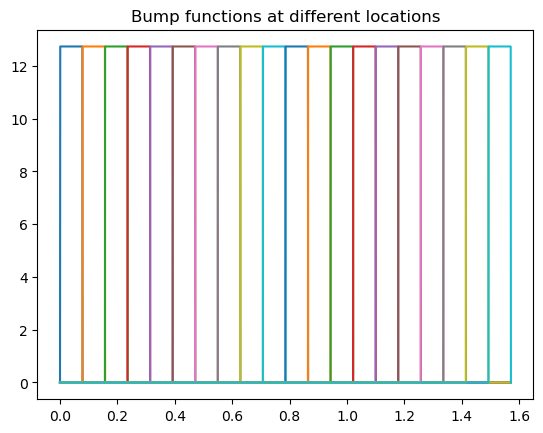

In [6]:
bump_values = vmap_indicator(x, epsilon_values, loc_values)

for i, loc in enumerate(loc_values):
    plt.plot(x, bump_values[:, 0, i])
plt.title("Bump functions at different locations")
plt.show()

## Computing the stiffness matrix
We have to compute
$$
A_{i,j} = \int_{\Omega} \psi_i \Delta^{-1} \psi_j =  \int_{\Omega} \int_{\Omega}\psi_i(y) G(x,y) \psi_j(y)dy \approx \sum_{k=1}\sum_{l=1}w_k\psi_{i}(x_k) G(x_k, x_l) w_l\psi_j(x_l) = \psi_i^\intercal G(X,X)\psi_j
$$


In [12]:
root_integration, w_integration = vmap_root_interval(x_q, w_q, support)
psi_matrix = indicator_vector(root_integration, epsilon_values, loc_values)
psi_matrix = psi_matrix * w_integration

In [18]:
# Define the Green's function 

# def G(x, y):
#     if x < y:
#         return -jnp.sin(x) * jnp.cos(y)
#     else: 
#         return -jnp.cos(x) * jnp.sin(y)

def G(x, y):
    def true_func(_):
        return -jnp.sin(x) * jnp.cos(y)

    def false_func(_):
        return -jnp.cos(x) * jnp.sin(y)

    return lax.cond(x < y, true_func, false_func, None)


# First, vectorize G over x
vectorized_G_x = vmap(G, in_axes=(0, None))

# Then, vectorize the result over y
vmap_G = vmap(vectorized_G_x, in_axes=(None, 0))

print(vmap_G(x, x).shape)

(2000, 2000)


In [37]:
def compute_sobolev_ip(psi_1, psi_2, x_1, x_2):
    return psi_1.T@ vmap_G(x_1, x_2)@psi_2

In [38]:
x_1 = root_integration[0]
x_2 = root_integration[1]
psi_1 = psi_matrix[0]
psi_2 = psi_matrix[1]
compute_sobolev_ip(psi_1, psi_2, x_1, x_2)

Array(-0.03896765, dtype=float64)

In [39]:
vmap_sobolev_first_axes = vmap(compute_sobolev_ip, in_axes=(0, None, 0, None))
vmap_sobolev_ip = vmap(vmap_sobolev_first_axes, in_axes=(None, 0, None, 0))

In [48]:
A = vmap_sobolev_ip(psi_matrix, psi_matrix, root_integration, root_integration)
jnp.allclose(A, A.T)

Array(True, dtype=bool)

# Solving the elliptic equation

We aim to solve the following PDE:

\begin{aligned}
u''(x) + u(x) = f(x) \\
u(0) = 0, u\Big(\frac{\pi}{2}\Big) = 0
\end{aligned}